# Digit Recognition Using K Nearest Neighbors

We've briefly gone over using K Nearest Neighbors in Python.

Let's go more in depth this time, as well as introduce basic cross validation. Cross validation will give us a more generalized measure of the model's scores, as well as help us to automatically tune the model (i.e. select the best `k` value).

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# What kind of object is digits?
digits = datasets.load_digits() 
digits

{'DESCR': " Optical Recognition of Handwritten Digits Data Set\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixels are counted in each block. This generates\nan input ma

In [8]:
#print digits.DESCR #The description of the dataset
#print digits.images.shape # The formatted array. This is an nparray of 1797 x 8 x 8 (1797 images having 8x8 pixels)
#print digits.data.shape #The raw data. This is an nparray of size 1797 x 64. Imagine each 8x8 image row's stacked into a single vector

#print digits.target.shape
#print digits.target_names

[0 1 2 3 4 5 6 7 8 9]


Let's take a look at a sample image

In [9]:
digits.images[0] #If you squint your eyes hard enough, the non zero values look roughly like a "0"

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

In [10]:
digits.data[0] #Same as above, but each row has been stacked into a single vector

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

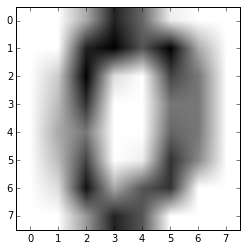

In [12]:
#Let's visualize what these images look like
#plt.imshow( digits.images[0])  
plt.imshow( digits.images[0], cmap=plt.cm.gray_r) #Color map, or cmap provides a mapping between the values, and the represented colors

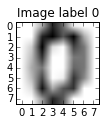

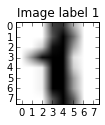

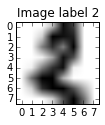

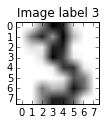

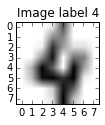

In [13]:
# # Lets look at a couple of these
for index in range(5):
    image = digits.images[index] 
    label = digits.target[index] 
    
    plt.figure( figsize=(5,5) ) 
    plt.subplot(2,3,index+1) 
    plt.imshow( image, cmap=plt.cm.gray_r)
    plt.title('Image label %i' % label)
#     image = digits.images[index]
#     label = digits.target[index]

#     plt.figure(figsize=(5,5))
#     plt.subplot(2,3,index+1)
#     plt.imshow(image,cmap=plt.cm.gray_r)
#     plt.title("Image label: %i" % label)

Okay, let's see if we can do a decent job of classifying digits. What we will do is, we will consider each row of digits.data to be a sample. 

X = digits.data, where the columns are features (i.e. pixel values), and the rows are samples
y = digits.target, where each element is the true label

In [14]:
# Sklearn is the package for machine learning in python.
# It has a host of machine learning tools/models, and various datasets

# http://scikit-learn.org/stable/ 
from sklearn import neighbors

In [16]:
n_samples = digits.images.shape[0]
X         = digits.data
y         = digits.target

(1797, 64)

We've just created our entire dataset. Ideally, what we would like to do before building a model, is to split this dataset into a training and testing dataset.

```
X = [ 0 1 4 6 8 8 ... 9 ]
    [ 1 5 7 2 0 0 ... 3 ]
    [ 4 3 5 9 8 0 ... 0 ]
    [ 3 5 0 0 1 1 ... 7 ]
    [ 4 4 9 3 9 4 ... 1 ]  
    [ 0 4 2 4 1 1 ... 1 ]
    
split to...

X = [ 0 1 4 6 8 8 ... 9 ]
    [ 1 5 7 2 0 0 ... 3 ]  Training Data Set
    [ 4 3 5 9 8 0 ... 0 ]
    [ 3 5 0 0 1 1 ... 7 ]
    ---------------------
    [ 4 4 9 3 9 4 ... 1 ]  Testing Data Set
    [ 0 4 2 4 1 1 ... 1 ]
    
```




```
Y = [ 1 ]
    [ 0 ]
    [ 9 ] 
    [ 7 ] 
    [ 3 ]
    [ 4 ]
    [ 0 ]
    
split too...

Y = [ 1 ]
    [ 0 ]
    [ 9 ]  Training Labels
    [ 7 ] 
    -----
    [ 3 ]
    [ 4 ]  Testing Labels
    [ 0 ]

```

Why cant we just select `rows 0 to #rows x 0.8` as training data, and `#rows x 0.8 to #rows` as testing data?
**When the user inserted or grabbed the original data, it could have been ordered already!.** i.e. What if when mining for image data, the user first grabbed all 0 images, then 1 images, then 2 images, and so on. Then if you split up the dataset, you'll only really have trained on a non-random set

In [17]:
# Luckily, there is a function in "cross_validation" called "train_test_split" that does exactly that for us
from sklearn.cross_validation import train_test_split

In [18]:
# This is an example of tuple unpacking. 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)  # Use 80% of the data for training

Now that we've split up our data, we can 'fit' or 'create' the model using our training data, and score on the testing data

In [19]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

In [24]:
# The "fit" function will be available in nearly all the models that you can import from sklearn
# In this case, fit just remembers the data and labels that you have passed in.
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')

There's a few parameters here. The ones to note are "weights", n_neighbors, and "metric" For now, let's use the defaults (which are set to grab distances by euclidean distance).

Now that we've fit the model, lets see how the model does in predicting the samples that it trained on.

In [26]:
# In predict, you pass in a matrix of samples you want to predict. 
# For each row in X_train it will return a prediction of the label
y_pred = knn.predict(X_train) 
y_pred

array([9, 4, 3, ..., 1, 7, 8])

Let's see how well it predicted on the training data. The scoring method for each model will be different, but for knn the scoring metric is #Correct/#Samples (or # Rows correctly predicted / # Total Rows )

In [27]:
np.sum(y_pred == y_train) / np.float64(len(y_train))

0.98399443284620736

SKlearn also has a `score` function built in. It handles the predction as well as score calculation steps in a single function.

In [28]:
# There's a function built into 
knn.score(X_train,y_train)

0.98399443284620736

In [29]:
# Let's score on the test data. Pretty good!
knn.score(X_test,y_test)

0.96944444444444444

What kind of images did the model not do well on?

* We can predict using the model on X_test, and save the predictions to y_pred.
* Then, we will check the indexes where y_pred != y_test.
* Finally, for a few of these, we can plot out the image

In [31]:
y_pred = knn.predict(X_test) 
y_pred

array([4, 7, 2, 0, 7, 5, 6, 9, 1, 9, 1, 2, 8, 1, 3, 1, 4, 9, 9, 3, 5, 4, 9,
       8, 4, 4, 2, 6, 5, 1, 5, 5, 3, 7, 0, 6, 2, 8, 3, 6, 2, 9, 9, 2, 8, 0,
       5, 1, 7, 4, 1, 8, 7, 5, 7, 7, 9, 2, 9, 5, 4, 5, 1, 7, 0, 8, 5, 8, 5,
       4, 0, 3, 3, 6, 9, 7, 3, 2, 8, 0, 1, 3, 0, 2, 7, 4, 8, 8, 1, 0, 5, 7,
       1, 1, 7, 7, 2, 4, 3, 0, 3, 5, 9, 0, 9, 4, 1, 4, 1, 1, 5, 0, 4, 1, 6,
       4, 8, 6, 0, 5, 7, 9, 3, 0, 2, 0, 1, 6, 7, 4, 7, 3, 8, 3, 1, 9, 3, 5,
       9, 1, 9, 2, 6, 5, 5, 7, 2, 3, 4, 9, 5, 1, 9, 6, 9, 2, 1, 5, 8, 9, 7,
       6, 4, 4, 7, 7, 2, 4, 8, 7, 0, 7, 7, 2, 6, 9, 4, 6, 5, 2, 2, 2, 1, 2,
       7, 8, 9, 2, 7, 2, 7, 9, 0, 1, 6, 9, 8, 6, 7, 2, 5, 9, 1, 1, 8, 3, 0,
       2, 2, 8, 6, 1, 4, 3, 4, 6, 5, 6, 0, 5, 8, 9, 7, 4, 5, 2, 3, 3, 6, 7,
       5, 7, 8, 8, 8, 6, 9, 8, 0, 3, 4, 3, 8, 5, 9, 3, 4, 9, 0, 9, 8, 9, 5,
       2, 5, 8, 7, 3, 0, 0, 8, 4, 8, 7, 2, 1, 5, 0, 6, 4, 8, 2, 9, 8, 8, 6,
       2, 3, 9, 4, 1, 2, 7, 9, 0, 4, 3, 2, 6, 1, 1, 8, 9, 7, 4, 0, 6, 5, 7,
       4, 8,

In [33]:
# Need to index by 0 at the end bc np.where returns a tuple per array dimension
inc_idx = np.where(y_pred != y_test)[0] 
inc_idx

array([ 15,  48,  49,  62,  87,  91, 109, 190, 211, 216, 226])

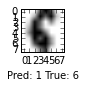

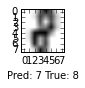

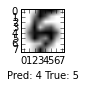

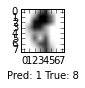

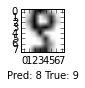

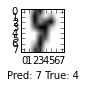

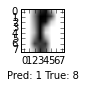

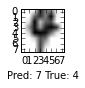

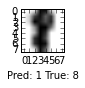

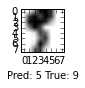

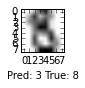

In [37]:
for plotidx, idx in enumerate(inc_idx):
    plt.figure( figsize=(10,10) ) 
    plt.subplot(1,len(inc_idx),plotidx+1)
    plt.imshow(X_test[idx].reshape( (8,8)) ,cmap=plt.cm.gray_r )
    plt.xlabel("Pred: %i True: %i" %( y_pred[idx], y_test[idx]))

# Cross Validation

The incorrect classifications seem somewhat reasonable. What if we just got lucky with choosing our datasets? If we run the chunk of code multiple times, we just get a different number each time.

To the whiteboard for cross validation...



In [38]:
# The sklearn cross_validation module also includes a nifty function called cross_val_score
from sklearn.cross_validation import cross_val_score

In [41]:
# cross_val_score takes in mainly the original model object, the entire dataset X, and the entire labelset y
# the argument cv indicates how many folds or partitions to build models for
# Return value: Score on the "test set" within each partition
cv_score = cross_val_score(knn, X, y, cv=10) 
cv_score

array([ 0.91351351,  0.96174863,  0.97790055,  0.96111111,  0.96089385,
        0.98882682,  0.98882682,  0.97752809,  0.95480226,  0.96022727])

In [42]:
cv_score.mean()

0.96453789195260331

# Exercise

Let's see if cross validation can give us a cleaner one step solution for picking the best `k` value.

Similar to last time, vary `k` from 1 to 30. With each `k`, create a new KNeighborsClassifier where n_neighbors = k. Then, use cross_val_score() with cv=5, and mean the results of the 5 test partitions. Append this number onto a list.

Once you have this list, use pyplot.plot (or plt.plot if you have pyplot aliased), to plot out the trend.

Which `k` do you get the best results for?

(Hint: Use np.argmax)

(Hint 2: If you start with an empty list, remember to add 1 to the argmax output)

In [ ]:
kList = []

for k in range(1,31):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn, X, y, cv=5)
    
    